In [1]:
import kaggle
import os

#os.environ['KAGGLE_CONFIG_DIR'] = "/Users/tungdinh/kaggle"

!kaggle datasets download -d faizalkarim/flood-area-segmentation 

flood-area-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
from zipfile import ZipFile
file_name = 'flood-area-segmentation.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall('datasets')
  print('Done')

Done


In [10]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import cv2

from util import load_data, preprocess_data, display_data
from unet import unet

In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')

GPU is available


In [12]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

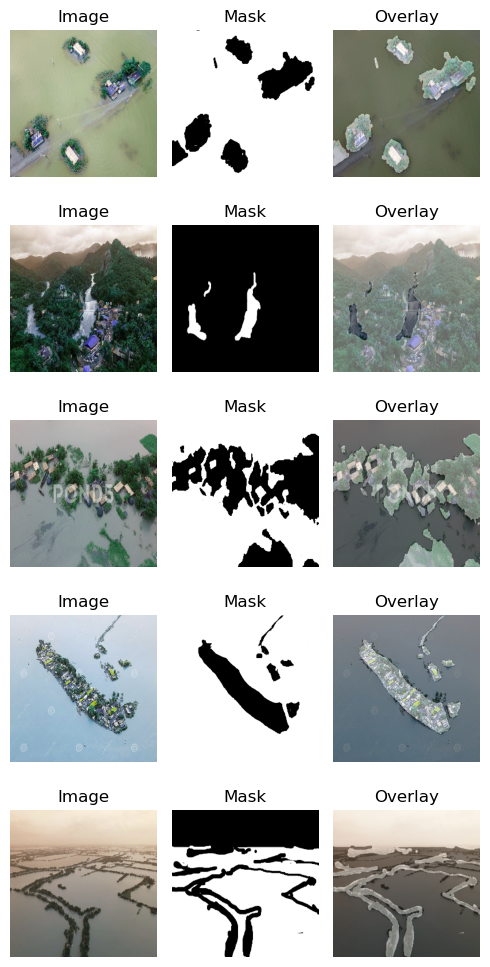

In [13]:
import random

# load data
dir_path = 'datasets/'
image_filenames, mask_filenames = load_data(dir_path)

# display the first 5 pairs of image and mask
random_indices = random.sample(range(0, len(image_filenames)), 5)
display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices], resize=INPUT_SIZE)

In [14]:
# preprocess data
with tf.device("/device:GPU:0"):
    # no augmentation due to limited computational resources
    # already have a large amount of data, roughly 12,000 images and masks
    images, masks = preprocess_data(dir_path, image_filenames, mask_filenames, input_size=INPUT_SIZE, augmented=True) 

In [15]:
# get shape
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (580, 256, 256, 3)
Shape of mask data: (580, 256, 256, 1)


In [16]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [ ]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best.h5', verbose=1, save_best_only=True)

In [ ]:
# Initialize the model
model = unet(INPUT_SHAPE, output_layer=1)
model.summary()

In [ ]:
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 20
with tf.device("/GPU:0"):
    history = model.fit(train_images, train_masks, batch_size=8, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])

In [ ]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('models/flood-damage-survey.h5')

In [ ]:
eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

In [17]:
from tensorflow.keras.models import load_model
# load the saved model if needed
model = load_model('models/flood-damage-survey.h5')

2023-06-21 22:28:03.914902: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 298ms/step


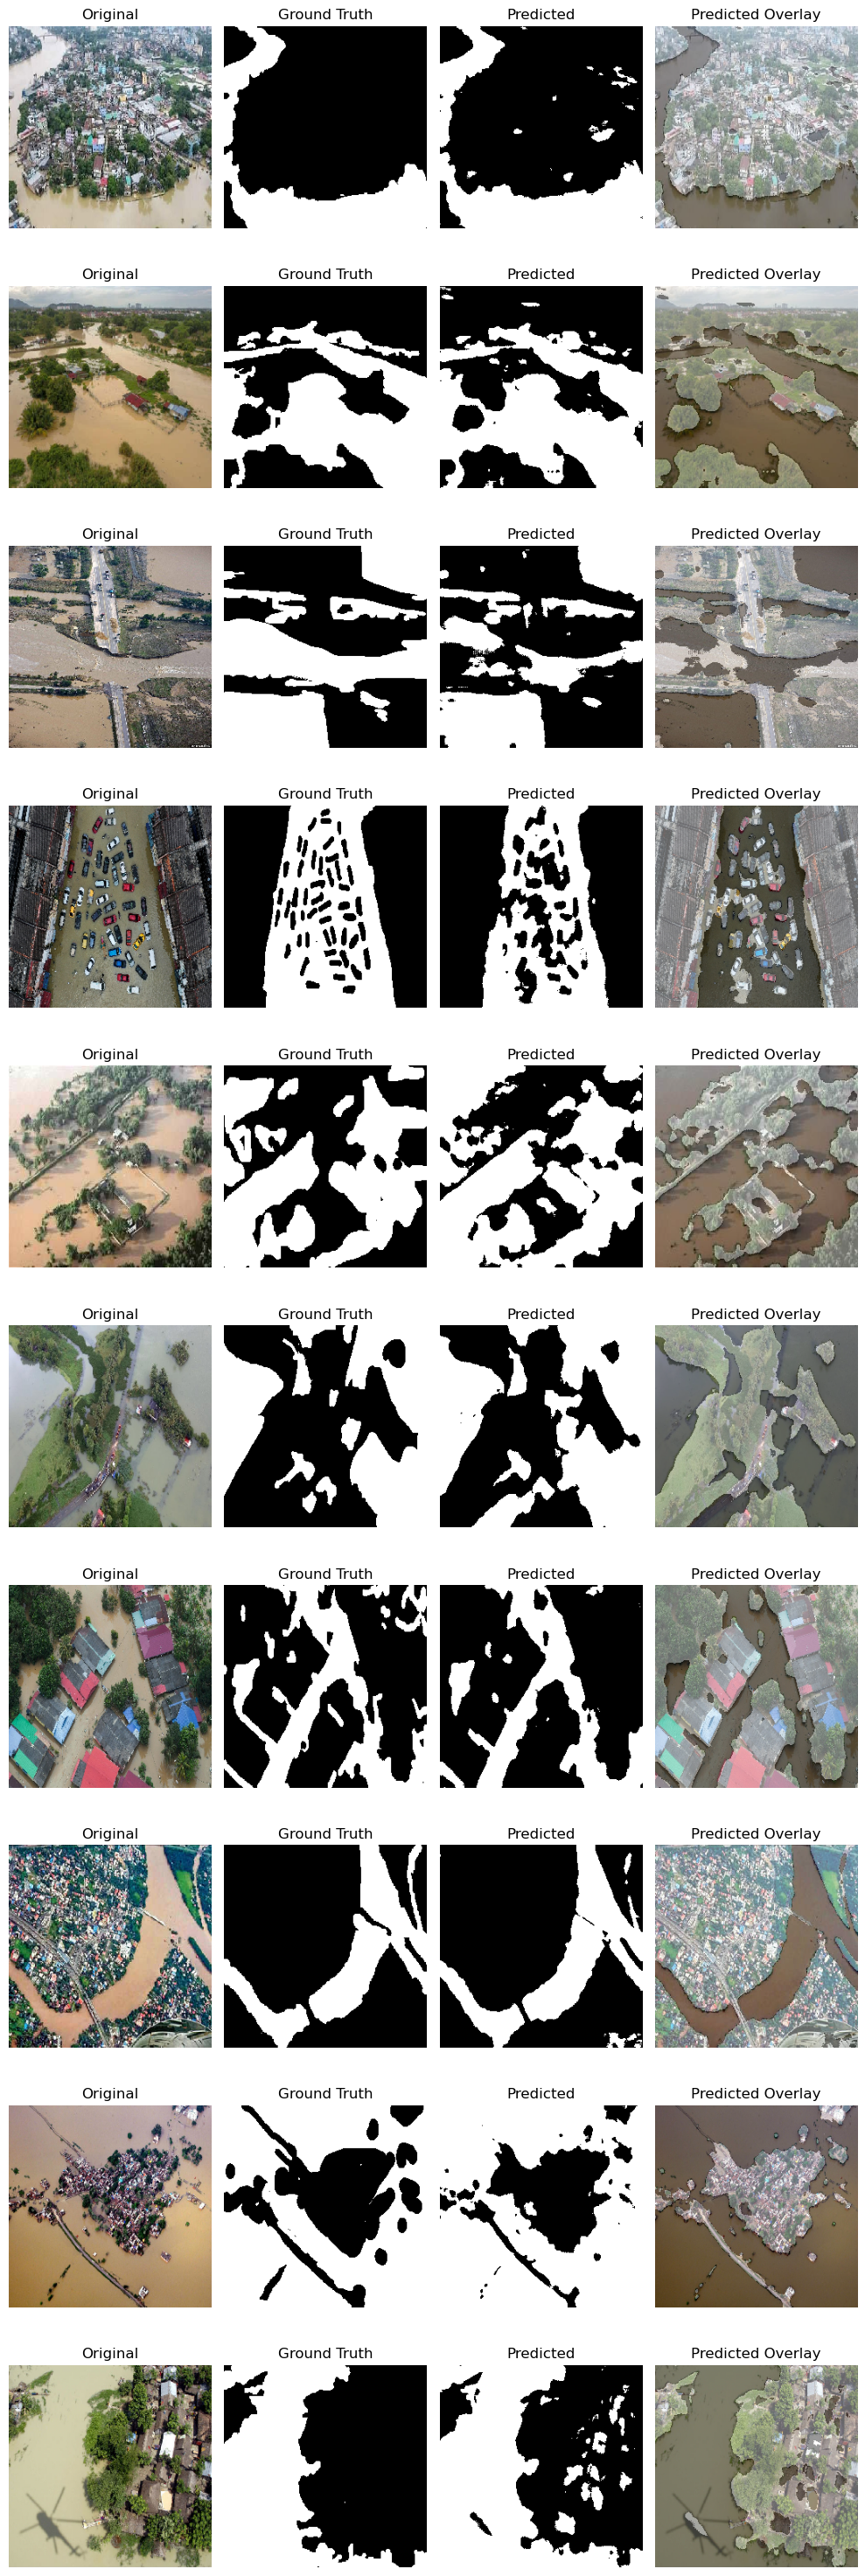

In [18]:
# display 10 random predictions
random_indices = random.sample(range(0, len(test_images)), 10)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    #mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    #mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    # result = image * inverted_mask + yellow_mask
    alpha = 0.4
    #predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(mask, cmap='gray')
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(image)
    axes[i, 3].imshow(tf.squeeze(cv2.bitwise_not(mask)), cmap='gray', alpha=0.4)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()


In [145]:
# Read the video
video_path = 'pexels-pradeep-k-liyanage-10217286-1920x810-30fps.mov'
cap = cv2.VideoCapture(video_path)

ret = True
#step = 30
frame_count = 0
while ret:
       
    ret, frame = cap.read()
    overlay = frame.copy()
    w, h, _ = frame.shape
    frame = cv2.resize(frame, (256, 256))   
    frame = frame/255     
    frame = np.expand_dims(frame, axis=0)
    alpha = 0.6

       
    predict = model.predict(frame)

    #predicted_overlay = cv2.addWeighted(overlay, alpha, predict#, 1 - alpha, 0)
    mask = cv2.resize(predict[0], (h, w))
    mask = np.where(mask >= 0.5, 1, 0)

    # Create a blank 3-channel image of the same size as the grayscale image
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Set the yellow color (255, 255, 0) for white pixels in the color image
    color_mask[mask > 0] = (255, 255, 0)
    #plt.imshow(color_mask, cmap=None)
    mask = color_mask.astype(np.uint8)

    predicted_overlay = cv2.addWeighted(overlay, alpha, mask, 1 - alpha, 0)
    cv2.imwrite('output/frames/{}.jpg'.format(frame_count), predicted_overlay)
    #plt.imshow(tf.squeeze(cv2.bitwise_not(color_mask)), cmap=None, alpha=0.2)
        
    break
    
    frame_count += 1
    #cv2.waitKey(0)
    #cap.release()
    #cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step


In [138]:
import os 

folder_path = './output/frames/'
file_names = os.listdir(folder_path)
# Sort the file names numerically, excluding non-numeric file names
sorted_file_names = sorted(
    [f for f in file_names if f.split(".")[0].isdigit()],
    key=lambda x: int(x.split(".")[0])
)

output_file = "./output/frames/output_video.mp4"
frame_width, frame_height = 810, 810  # Specify the desired frame size
fps = 22  # Specify the frames per second
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Specify the video codec (e.g., "mp4v", "XVID", etc.)
output_video = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

for frame_file in sorted_file_names:
    frame_path = os.path.join(folder_path, frame_file)
    frame = cv2.imread(frame_path)

    # Resize the frame if necessary
    #frame = cv2.resize(frame, (frame_width, frame_height))

    output_video.write(frame)

output_video.release()
cv2.destroyAllWindows()